# Forecasting bank customer deposit balances

In this project we aim to predict customer deposit balances based on demographics and credit profiles using: Linear Regression, K-Nearest Neighbors, Support Vector Machine and Random Forest.

Since the dataset is cross-sectional rather than longitudinal, we cannot strictly "forecast" future balance fluctuations. Instead we aim to estimate the expected deposit amount based on current customer profiles. We treat the `Balance` as a continuous response variable and we aim to verify whether the demographic and credit features are statistically associated with higher wealth accumulation.


Author: Maddalena Prandini & Pascaline Byiringiro

# 1. Data preparation
Firstly we import the needed packages for manipulating the dataset and perform various analysis with different tools.

We also must remove columns, from the csv file we imported, that are just identifiers. `RowNumber`, `CustomerId`, and `Surname` are unique to each person and contain no mathematical pattern that helps in our analysis. Therefore, we drop these columns from the dataset.


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data 
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [28]:
# Drop identifier columns. These columns do not contribute to the prediction and may introduce noise
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

Machine learning models require numeric data: we have to convert categorical data into numerical data. Text columns like `Geography` and `Gender` must be converted into numbers.

- For `Geography`, which is a nominal variable (no order), we use **One-Hot Encoding**. This method creates new binary columns for each category, indicating the presence ($1$) or absence ($0$) of that category.
- For `Gender`, which is a binary variable (two categories), we use **Binary Encoding**, mapping `Male` to $1$ and `Female` to $0$. 

In [29]:
# Binary encoding for Gender
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# One-Hot Encoding for Geography (nominal variable)
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)     # 'drop_first=True' avoids multicollinearity so we drop one dummy variable

The next step is defining the target variable and the features. Since our goal is to estimate the deposit amount based on current customer profiles, our target variable ($y$) is `Balance`. To prepare the data, we separate the dataset: 
- $y$ (Target): Contains only the `Balance` column
- $X$ (Features): Contains all other columns (after dropping `Balance`)

This separation allows our models to learn the mathematical relationship between customer characteristics (the features) and their financial status (the target).

In [30]:
# Target variable: customer deposit balance
y = df['Balance'] 

# Feature matrix
X = df.drop(['Balance'], axis=1) # All columns except 'Balance' 

To objectively evaluate the model's performance on unseen data, we partition the dataset into a Training Set ($80\%$) and a Testing Set ($20\%$).

We set 'random_state=42' to ensure the split is deterministic. This guarantees that every time the code is executed, the exact same data points are assigned to the train and test sets, ensuring reproducibility and fair comparisons between different models.

In [31]:
# Split the dataset into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

Since our dataset have mixed scales (because `Age` for example is small and `EstimatedSalary` is huge), **feature scaling** is necessary.

This step is critical for distance-based algorithms like KNN and SVM. Without scaling, features with larger numerical ranges (like `EstimatedSalary`) would mathematically dominate the distance calculations, causing the model to effectively ignore smaller-scale features (like `Age`). We employ StandardScaler to normalize all continuous features, centering them at a mean of $0$ with a standard deviation of $1$, ensuring all variables contribute equally. 

In [32]:
# Feature scaling 
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to test data
X_test_scaled = scaler.transform(X_test)

In [33]:
print("Data preparation completed successfully.")
print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")


Data preparation completed successfully.
Training set shape: (8000, 11)
Test set shape: (2000, 11)


## 2. Exploratory Data Analysis (EDA)

After preparing the dataset by cleaning, encoding categorical variables, and defining the feature-target structure, we perform **Exploratory Data Analysis (EDA)**. Our primary focus is to examine the distribution of the target variable. This step is critical for identifying skewness, potential outliers, or structural anomalies that may negatively impact the performance of our regression models.

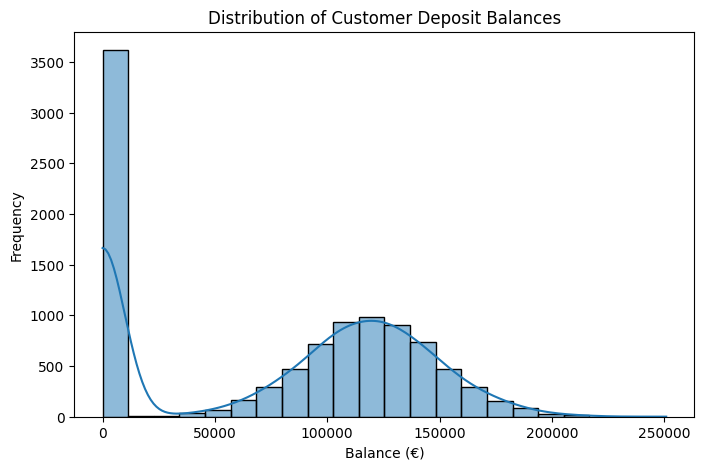

In [34]:
import matplotlib.pyplot as plt    
import seaborn as sns               

plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True)
plt.title('Distribution of Customer Deposit Balances')
plt.xlabel('Balance (€)')
plt.ylabel('Frequency')
plt.show()

As we can see from the histogram, the pattern is not very usual because there are many customers with $0$ balance; having a $0$ balance could indicate lots of things: for example, customers who have just opened an account and haven't deposited money yet, or customers who have withdrawn all their funds. 

Indeed, the histogram reveals a bimodal distribution with a significant spike at $0$. This indicates the dataset has **zero-inflated distribution**: a large segment of customers holds a balance of zero, while the remaining customers follow a roughly normal distribution centered between € $100,000$ and $150,000$ . 


With respect of this spike at $0$:
- Linear regression may struggle because it assumes a continuous, smooth relationship and normally distributed errors. This is likely to violate these assumptions potentially leading to reduced predictive accuracy.

- KNN is a non-parametric and distance-based model that can adapt more flexibly to irregular target distributions. However, its performance may still be influenced by the concentration of zero-balance observations in feature space.

- SVM also does not assume a specific distribution for the target variable. However performance depends critically on kernel choice and regularization, particularly in the presence of zero-inflated targets.

- Random Forest is theoretically best suited for this type of discontinuous data. Since it is based on Decision Trees, it creates binary splits. This allows the model to naturally segment the "Zero Balance" customers from the "Active Balance" customers without forcing a smooth line through both groups, potentially handling the zero-inflation better than linear or distance-based models.

In [35]:
zero_balance_share = (y == 0).mean()
print(f"Share of zero balances: {zero_balance_share:.2%}")


Share of zero balances: 36.17%


Approximately $36.17\%$ of customers in the dataset have a zero balance, confirming the presence of a substantial mass point at zero.

Even though many customers have a $0$ balance (zero-inflation), we kept the dataset as-is. In real banking, having an empty account is common, not an error. We treat this as a natural feature of the data and will use it to compare how well different regression models handle these "empty" accounts.

## 3. LINEAR REGRESSION

We begin our modeling phase with a **Linear Regression** model. Linear Regression is a simple and interpretable supervised learning algorithm that assumes a linear relationship between the features and the target variable. We are using the Ordinary Least Squares (OLS) method to estimate the coefficients of the linear equation, minimizing the sum of squared residuals between observed and predicted values.

This will theoretically lead to biased estimates, where the model underestimates high-value customers and overestimates low-value ones, resulting in a high Root Mean Squared Error ($RMSE$) and a reduced predictive performance. 



In [36]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Initialize the Linear Regression model 
lin_reg = LinearRegression()

# Fit the model on the training data: we are training the model to learn the relationship between features and target variable
lin_reg.fit(X_train_scaled, y_train) 

# Evaluate the model on the test data: we are obtaining the predicted values for the test set
y_pred = lin_reg.predict(X_test_scaled) 

# Calculate other evaluation metrics
ssr = np.sum((y_test - y_pred)**2) # Sum of the squared differences. Here **2 means squared
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Model Performance ")
print(f"Sum of Squared Residuals (SSR): {ssr:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R^2): {r2:.4f}")

Linear Regression Model Performance 
Sum of Squared Residuals (SSR): 5799441625252.72
Mean Squared Error (MSE): 2899720812.63
Root Mean Squared Error (RMSE): 53849.06
Mean Absolute Error (MAE): 46625.44
R-squared (R^2): 0.2485


Looking at the results we can confirm our expectations. As we can see from the metrics: 

- linear regression model has an high $SSR$ by ~ $5.8$ trillion. This large value confirms that the total deviation between our predicted balances and the actual balances is massive. Since $SSR$ represents the total variance that our model failed to explain, a lower $SSR$ would be better. This indicates that our linear regression model is not capturing the underlying patterns in the data effectively, likely due to the zero-inflated distribution of the target variable.

- $R^2 = 0.2485$ indicates that only about $24.85\%$ of the variance in the target variable is explained by our linear regression model. This low $R^2$ value suggests that the model has limited predictive power and is not effectively capturing the relationship between the features and the target variable. Basically ~ $75\%$ of the factors that determine a customer's balance are not captured by this linear equation. This is expected because the relationship is likely non-linear and discontinuous due to the zero-balance customers.

- $RMSE > MAE$. Since $RMSE$ squares errors before averaging, it disproportionately penalizes large errors. A significant gap between $RMSE$ and $MAE$ suggests the presence of outliers or "big misses." In our context, this likely occurs when the model predicts a generic average for a customer who actually has zero balance, generating a massive squared error term.






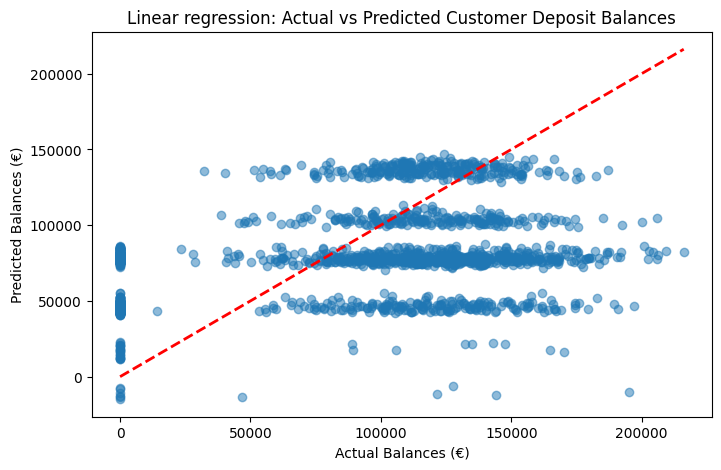

In [37]:
# Visualize the results
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)

# Plot a diagonal line for reference (y=x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel('Actual Balances (€)')
plt.ylabel('Predicted Balances (€)')
plt.title('Linear regression: Actual vs Predicted Customer Deposit Balances')
plt.show()

The "Actual vs. Predicted" scatter plot reveals two distinct and problematic patterns that explain our model's poor performance (as indicated by the low $R^2$ score of $0.2485$):

1. The "vertical wall" at zero (**Zero-Inflation Issue**): we see a vertical line of predictions ranging from negative values up to ~ $100,000$ €. This represents the ~ $36\%$ of customers with zero balance. The linear model fails to recognize "Zero Balance" as a distinct state and instead tries to predict a continuous number for these empty accounts leading to many underpredictions for customers who actually have a balance.

2. The presence of "Horizontal Bands" (**Stratification**): the predictions for non-zero customers appear to cluster into four distinct horizontal levels or bands. This suggests that the model is not smoothly adjusting predictions based on continuous variables like `Age` or `EstimatedSalary`. Instead, it seems to be relying heavily on a specific discrete feature (categorical or integer-based) to make crude "step-wise" guesses.

To confirm which feature is causing this "banding" effect, we will inspect the model's coefficients.

In [38]:
coefficients = pd.DataFrame({
    # Using hasattr, a built-in function that checks if an object has a specific attribute
    'Feature': X_train_scaled.columns if hasattr(X_train_scaled, 'columns') else X.columns,  
    'Weight': lin_reg.coef_
})

# Calculate absolute weight to identify the most influential features
coefficients['Abs_Weight'] = coefficients['Weight'].abs()

# Display features sorted by their impact
print(coefficients.sort_values(by='Abs_Weight', ascending=False))

              Feature        Weight    Abs_Weight
9   Geography_Germany  24798.505179  24798.505179
4       NumOfProducts -18165.869977  18165.869977
8              Exited   2547.164549   2547.164549
1              Gender   1076.317570   1076.317570
5           HasCrCard  -1052.939278   1052.939278
0         CreditScore    760.376188    760.376188
7     EstimatedSalary    674.338044    674.338044
2                 Age   -638.703775    638.703775
3              Tenure   -318.789322    318.789322
10    Geography_Spain   -158.457907    158.457907
6      IsActiveMember    -62.894641     62.894641


The coefficient analysis above suggests that our model is creating a "prediction grid" based on just two variables: `Geography` and `Number of Products`. To confirm this we are going to inspect the unique values of these two features in the original dataset. The inspection show that we have only $3$ unique values for `Geography` (France, Spain, Germany) and $4$ unique values for `Number of Products` ($1$, $2$, $3$, $4$). 

From these results we can also see that the "credit profile" features (like `Credit Score`, `Tenure` ...) are not being effectively utilized by the linear regression model. Instead, the model is primarily relying on the categorical variable `Geography` and the discrete variable `Number of Products` to make its predictions. This leads to the observed "horizontal bands" in the scatter plot, where predictions cluster around specific values corresponding to combinations of these two features.

In [39]:
# We load the raw data into a temporary variable just to check its contents
raw_check = pd.read_csv('Churn_Modelling.csv')

print("NATIONALITY CHECK")
countries = raw_check['Geography'].unique()
print(f"Number of Countries: {len(countries)}")
print(f"List of Countries: {countries}")

# Checking the % of German customers to verify the 'Minority Shift' theory
germany_share = (raw_check['Geography'] == 'Germany').mean()
print(f"Share of German Customers: {germany_share:.2%}")
# Also checking the % for other countries
france_share = (raw_check['Geography'] == 'France').mean()
spain_share = (raw_check['Geography'] == 'Spain').mean()
print(f"Share of French Customers: {france_share:.2%}")
print(f"Share of Spanish Customers: {spain_share:.2%}")


print("\nPRODUCT CHECK")
products = np.sort(raw_check['NumOfProducts'].unique())
print(f"Possible Product Counts: {len(products)}")
print(f"List of Options: {products}")
# Expected: [1 2 3 4]

print("\nDISTRIBUTION CHECK ")
print(raw_check['NumOfProducts'].value_counts().sort_index())

NATIONALITY CHECK
Number of Countries: 3
List of Countries: ['France' 'Spain' 'Germany']
Share of German Customers: 25.09%
Share of French Customers: 50.14%
Share of Spanish Customers: 24.77%

PRODUCT CHECK
Possible Product Counts: 4
List of Options: [1 2 3 4]

DISTRIBUTION CHECK 
NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64


To sum up, the "Actual vs. Predicted" scatter plot exhibits a striking **horizontal banding pattern**, where predictions cluster into distinct levels rather than following the diagonal line. Our analysis of the model coefficients reveals that this is not a random error, but a direct mathematical consequence of how the Linear Regression model oversimplified the problem.


The dominant visual feature (four distinct horizontal clusters)is driven by the `NumOfProducts` feature.
- The model assigns a massive negative weight of approximately  € $-18,166$  per product
- Since every customer holds exactly $1$, $2$, $3$, $4$ products, the model forces every prediction into one of four rigid "base levels" subtracting  € $18,166$, € $36,332$, € $54,498$, or € $72,664$ respectively
- Because continuous variables like `Age` and `EstimatedSalary` were assigned negligible weights (effect < € $1,000$ ), they are too weak to smooth out these large steps, leaving the bands clearly visible

The second most influential feature is `Geography_Germany`, with a positive weight of approximately +€24,798.
* (The majority: $75\%$) = Customers from France and Spain do not receive this "bonus"
* (The minority: $25\%$) = German customers receive the +€$24,798$ shift. This lifts their predictions upwards, effectively creating a secondary "shadow grid" floating above the main bands


Mathematically, there are $8$ possible starting points ($4$ product levels $\times$ $2$ geography states). However, visually we perceive only $4$ main bands because the non-German group is much larger ($75\%$ of data), making their $4$ bands the dominant visual pattern. Also note that, as we approximatelly saw in the EDA, the distribution is bimodal and the observation inside the four bands we are talking about are following a normal distribution between centred between € $100,000$ and € $150,000$.


*Conclusion* : As expected, the Linear Regression performed poorly; but using this model as a baseline was useful to understand the data structure and the challenges posed by zero-inflated distributions. We can also consider that linear analysis as a diagnostic tool: by running it and observing the low $R^2$ ($0.2485$) and the high RMSE ($53,849.06$), we empirically proved that the relationship between demographics and balance is non-linear, and also the one between the credit profile and balance. The model fails to capture the zero-inflation, effectively averaging the '0' and 'non-0' populations. This confirms that the data violates the OLS normality assumption. For this reason, we decided to move to more flexible, non-linear models that could better capture the complex patterns in the data.

## 4. K-NEAREST NEIGHBORS (KNN) REGRESSION

The **K-Nearest Neighbors (KNN)** algorithm is a non-parametric, instance-based supervised learning algorithm that predicts the target variable based on the average of the k-nearest neighbors in the feature space. Unlike linear regression, KNN does not assume a specific functional form for the relationship between features and the target variable, making it more flexible in capturing complex patterns.

KNN regression is particularly well-suited for datasets with non-linear relationships and irregular distributions, such as our zero-inflated target variable. By considering the local neighborhood of each data point, KNN can adapt to the underlying structure of the data without being constrained by global assumptions.






Running hyperparameter search (k=1 to 40)...

OPTIMIZATION RESULTS
Optimal K found: 37
Best R^2 Score: 0.2937
Lowest RMSE: €52,204.51
Mean Absolute Error (MAE): €42,251.91


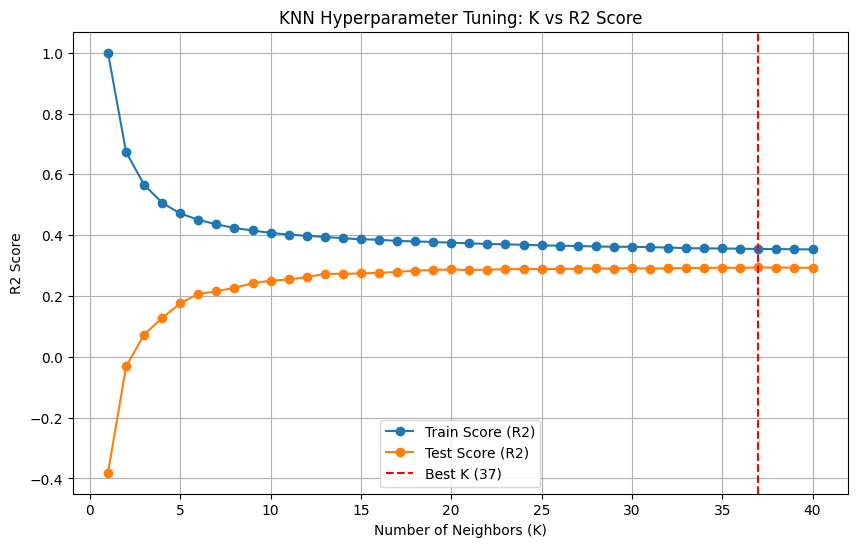

In [41]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np

# Search for Best Parameters
print("Running hyperparameter search (k=1 to 40)...")
k_values = range(1, 41)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # Store R2 scores
    train_scores.append(knn.score(X_train_scaled, y_train))
    test_scores.append(knn.score(X_test_scaled, y_test))

# Select the Best K based on highest Test R2 score
best_index = np.argmax(test_scores)
best_k = k_values[best_index]
best_r2 = test_scores[best_index]

# Re-train with Best K to get correct MAE/RMSE
best_model = KNeighborsRegressor(n_neighbors=best_k)
best_model.fit(X_train_scaled, y_train)
best_predictions = best_model.predict(X_test_scaled)

best_rmse = np.sqrt(mean_squared_error(y_test, best_predictions))
best_mae = mean_absolute_error(y_test, best_predictions)

# Print Results
print(f"\nOPTIMIZATION RESULTS")
print(f"Optimal K found: {best_k}")
print(f"Best R^2 Score: {best_r2:.4f}")
print(f"Lowest RMSE: €{best_rmse:,.2f}")
print(f"Mean Absolute Error (MAE): €{best_mae:,.2f}")

# Plot the Trade-off (Bias vs Variance)
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_scores, label='Train Score (R2)', marker='o')
plt.plot(k_values, test_scores, label='Test Score (R2)', marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best K ({best_k})')
plt.title('KNN Hyperparameter Tuning: K vs R2 Score')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('R2 Score')
plt.legend()
plt.grid(True)
plt.show()

The plot above shows the $R^2$ curves illustrating the bias-variance trade-off as we vary the number of neighbors (K) from $1$ to $40$. Our goal is to find the "middle ground" that balances underfitting and overfitting. The optimal K value of $37$ represents the best compromise between bias and variance, maximizing predictive accuracy on unseen data. Thanks to this hyperparameter tuning, we were able to improve the model's performance compared to the linear regression baseline ($R^2$ improved from $0.2485$ with linear regression to $0.2937$ with KNN).

Moreover, we could observe e big gap between $RMSE$ and $MAE$ (€ $52,204.51 > 42,251.91$). Although the gap between the two value seems to be higher than the one we observed with linear regression, even if we have to consider that both $RMSE$ and $MAE$ decreased significantly ($53,849.06 > 46,625.44$). This means that KNN is making much more accurate predictions overall, even if some large errors still exist due to the zero-inflated nature of the target variable. 


In [42]:
# Train Final Model with Best K for Residuals 
final_knn = KNeighborsRegressor(n_neighbors=best_k)
final_knn.fit(X_train_scaled, y_train)
y_pred_final = final_knn.predict(X_test_scaled)
residuals = y_test - y_pred_final

In here we are instanciating the final KNN model using the optimal K value identified from the hyperparameter search. This model is then trained on the entire training dataset to learn the underlying patterns and relationships between the features and the target variable. 

We are also calculating the residuals which isolates the prediction errors to help diagnose if the model is capturing the data's underlying patterns correctly

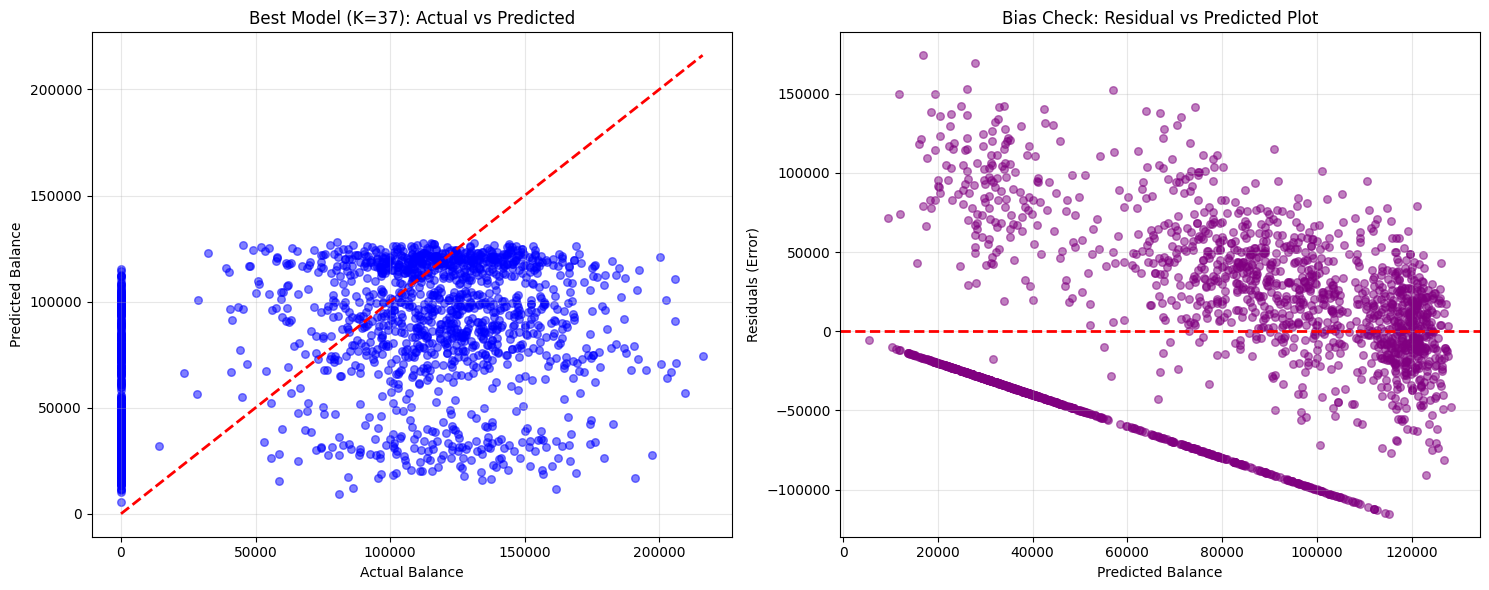

In [43]:
# Residual Analysis Plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred_final, alpha=0.5, color='blue', s=30)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Balance')
axes[0].set_ylabel('Predicted Balance')
axes[0].set_title(f'Best Model (K={best_k}): Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Residual vs Predicted Plot
axes[1].scatter(y_pred_final, residuals, alpha=0.5, color='purple', s=30)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Balance')
axes[1].set_ylabel('Residuals (Error)')
axes[1].set_title('Bias Check: Residual vs Predicted Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The most striking feature across both plots is the pronounced issues arising from the zero-inflated nature of the target variable:


1. In the "**Actual vs. Predicted**" plot 
    ideally we would have to see points clustered tightly along the red dashed diagonal line. Instead, we see a diffuse "cloud" with a massive vertical line of blue dots on the far left. The model is failing to accurately predict balances for customers with zero balance, leading to a wide spread of predictions for these individuals. This indicates that the model is not effectively capturing the characteristics of zero-balance customers, resulting in significant prediction errors.

    This vertical line in zero means that for hundreds of customers who have absolutely no money in their account, the model is predicting balances ranging anywhere from zero € up to € $120,000$ . It is failing to identify the "zero-balance" segment. Additionally, the model seems unable to predict high balances; notice how the blue dots flatten out and rarely go above € $130,000$ on the Y-axis, even when the Actual Balance is much higher.


2. In the "**Residuals vs. Predicted**" plot
    we would expect the residuals to be randomly scattered around the horizontal line at 0, indicating that the model's errors are unbiased and homoscedastic. However, we observe a pronounced funnel shape, particularly for low predicted balances. The residuals for zero-balance customers are widely spread, indicating that the model is making large errors in this segment. This pattern suggests that the model's performance is inconsistent across different levels of predicted balance, with significant challenges in accurately predicting low or zero balances.

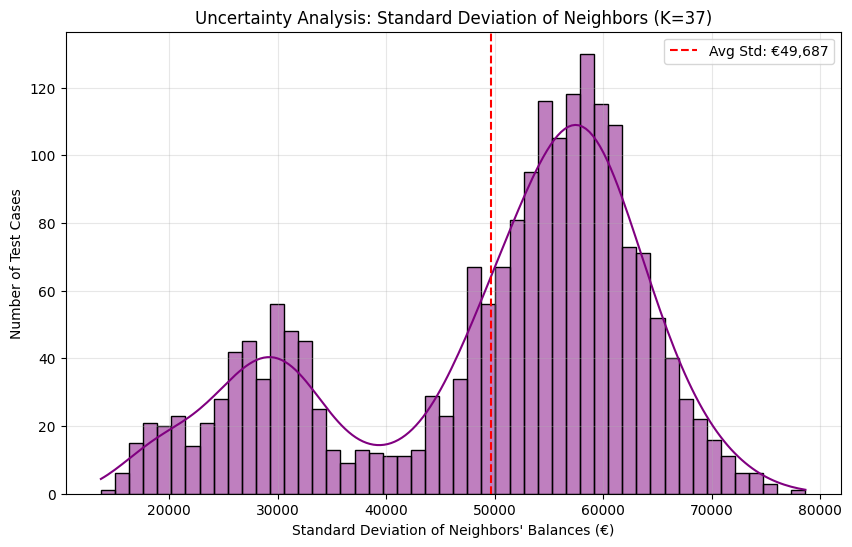

KNN Confusion Report: 
Average spread (Std Dev) of neighbors: €49,686.99
Number of predictions based on a mix of 'Zero' and 'Rich' neighbors: 1615 out of 2000


In [44]:
# Here we analyze the uncertainty of our KNN predictions by examining the variability of the neighbors' balances used for each prediction

# Finding the neighbors for every point in the test set
distances, indices = final_knn.kneighbors(X_test_scaled)

# Here we retrieve the actual Balance values of those neighbors
neighbor_balances = y_train.iloc[indices.flatten()].values.reshape(indices.shape)

# Calculate the Standard Deviation of balances for each test point's neighborhood
neighbor_std = np.std(neighbor_balances, axis=1)

plt.figure(figsize=(10, 6))
sns.histplot(neighbor_std, bins=50, kde=True, color='purple')
plt.title(f'Uncertainty Analysis: Standard Deviation of Neighbors (K={best_k})')
plt.xlabel('Standard Deviation of Neighbors\' Balances (€)')
plt.ylabel('Number of Test Cases')
plt.axvline(x=np.mean(neighbor_std), color='red', linestyle='--', label=f'Avg Std: €{np.mean(neighbor_std):,.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

zero_mix_count = np.sum((np.min(neighbor_balances, axis=1) == 0) & (np.max(neighbor_balances, axis=1) > 0))
print(f"KNN Confusion Report: ")
print(f"Average spread (Std Dev) of neighbors: €{np.mean(neighbor_std):,.2f}")
print(f"Number of predictions based on a mix of 'Zero' and 'Rich' neighbors: {zero_mix_count} out of {len(X_test_scaled)}")

This histogram visualizes the internal "confusion" of the KNN model by calculating the standard deviation of the $37$ neighbors used for each prediction. The result shows that for $1,615$ out of $2,000$ test cases ($80.8\%$), the model's $37$ nearest neighbors included a mix of both "zero balance" and "positive balance" customers. This proves that customers with identical profiles (same `Age`, `Score`, `Geography`) behave inconsistently: one opens an account (and deposits money) while another does not. Moreover, the average standard deviation of roughly € $50,000$ implies that any single prediction has an "error bar" of +/- €$50,000$ based on its own neighbors. 

All this confirms that the low $R^2$ is not due to model rigidity (as in Linear Regression) but due to data indistinguishability. Since the features cannot separate "Zero" vs "Rich" neighbors, the model averages them to predict a middle ground value that rarely exists in reality.

*Conclusion*: To sum up, Moving from Linear Regression to K-Nearest Neighbors yielded a modest performance improvement, raising the $R^2$ from $0.2485$ to $0.2937$ and reducing the $RMSE$ by approximately $1,600$ €. However, the nature of the error has shifted rather than disappeared: where Linear Regression failed through rigidity (creating "horizontal bands" by forcing customers into fixed buckets), KNN fails through confusion. The KNN model struggles to accurately identify and predict zero-balance customers, resulting in a wide range of predicted balances for these individuals. 

This implies that customers with identical demographics or credit profile often behave completely differently. This proves that demographics and credit features alone are insufficient to distinguish between savers and non savers.

While KNN offers more flexibility than Linear Regression, it still faces significant challenges in capturing the underlying patterns of the data, particularly for the zero-inflated segment. Since neither the global rules of Linear Regression nor the local averaging of KNN could effectively handle the "Zero-Inflated" structure of this data, we need a more powerful approach. The next logical step is Support Vector Regression (SVR), which uses kernels to project data into higher dimensions, potentially allowing us to draw the complex, non-linear boundaries needed to separate empty accounts from high-value ones.

## 5. SUPPORT VECTOR MACHINE (SVM) REGRESSION

Since neither the global rules of Linear Regression nor the local averaging of KNN could effectively handle the "Zero-Inflated" structure of this data, we need a more powerful approach. The next logical step is **Support Vector Machine (SVM)** with regression (SVR). Unlike previous models, SVR utilizes the **Kernel Trick** to project our data into higher-dimensional space. Theoretically, this allows the model to find a linear hyperplane in that higher dimension that corresponds to a complex, non-linear boundary in our original space, potentially separating the "Zero Balance" customers from the "Active" ones more effectively. 

We will employ the Radial Basis Function (RBF) kernel. This kernel is specifically designed to handle non-linear relationships by measuring similarity based on distance (Gaussian distribution). This flexibility should allow the SVR model to wrap around the complex data structure rather than forcing a straight line through it.


In [45]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time

# Here Grid Search will search for the best hyperparameters for SVR using RBF kernel
param_grid_svr = {
    'kernel': ['rbf'],  # RBF is the standard for non-linear problems
    'C': [10, 100, 1000],  # Controls "Hardness" of the margin (higher = stricter). Regularization parameter
    'gamma': ['scale', 0.1, 0.01],  # Controls "Curvature" (higher = complex curves)
    # We decided to test high epsilon values (margin of tolerance for errors) in order to capture the 
    # main trends in the data and avoid overfitting to noise
    'epsilon': [100, 1000, 5000]  
}

# Initialization of SVR
svr = SVR()

# Set up Grid Search (Using 3-fold CV to save time, as SVR is slow)
grid_search_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid_svr,
    cv=3, # 3-fold Cross-Validation
    scoring='r2', # Using R^2 as the evaluation metric
    n_jobs=-1,  # Use all CPU cores
    verbose=2 
)

In here is used the **$3$-fold cross-validation** to speed up the hyperparameter search process. SVR can be computationally intensive, especially with larger datasets and complex parameter grids. By using $3$-fold CV instead of the more common $5$- or $10$fold, we reduce the number of model trainings required during the grid search, thus saving time while still obtaining a reasonable estimate of model performance for hyperparameter tuning.

The $3$-fold CV is done by splitting the training data into $3$ equal parts. In each iteration, $2$ parts are used for training the model and the remaining part is used for validation. This process is repeated $3$ times, with each part serving as the validation set once. The average performance across all $3$ folds is then used to evaluate the model's effectiveness for each combination of hyperparameters in the grid search.

In [46]:
# Fit the model: basically we are training multiple SVR models with different hyperparameter combinations
print("Starting SVR Hyperparameter Search...")
start_time = time.time()
grid_search_svr.fit(X_train_scaled, y_train)
end_time = time.time()

print(f"\nSearch Complete in {end_time - start_time:.2f} seconds.")
print(f"Best SVR Parameters: {grid_search_svr.best_params_}")
print(f"Best R^2 Score: {grid_search_svr.best_score_:.4f}")

# Save the best model
best_svr = grid_search_svr.best_estimator_

Starting SVR Hyperparameter Search...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .........C=10, epsilon=100, gamma=scale, kernel=rbf; total time=   8.3s
[CV] END ...........C=10, epsilon=100, gamma=0.1, kernel=rbf; total time=   8.3s
[CV] END .........C=10, epsilon=100, gamma=scale, kernel=rbf; total time=   8.4s
[CV] END .........C=10, epsilon=100, gamma=scale, kernel=rbf; total time=   8.4s
[CV] END ...........C=10, epsilon=100, gamma=0.1, kernel=rbf; total time=   9.5s
[CV] END ...........C=10, epsilon=100, gamma=0.1, kernel=rbf; total time=   9.5s
[CV] END ..........C=10, epsilon=100, gamma=0.01, kernel=rbf; total time=   9.4s
[CV] END ..........C=10, epsilon=100, gamma=0.01, kernel=rbf; total time=   9.5s
[CV] END ........C=10, epsilon=1000, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END ........C=10, epsilon=1000, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END ........C=10, epsilon=1000, gamma=scale, kernel=rbf; total time=   8.5s
[CV] END .

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on the test set. We use the best model found by GridSearch to predict data it has never seen before
y_pred_svm = best_svr.predict(X_test_scaled)

# Metrics 
svm_test_r2 = r2_score(y_test, y_pred_svm)
svm_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_svm))
svm_test_mae = mean_absolute_error(y_test, y_pred_svm)

print("SVM performance on test set: ")
print(f"R^2 Score: {svm_test_r2:.4f}")
print(f"RMSE: €{svm_test_rmse:,.2f}")
print(f"MAE: €{svm_test_mae:,.2f}")

SVM performance on test set: 
R^2 Score: 0.2888
RMSE: €52,387.31
MAE: €39,034.92


As we can see from the results, there is a slight difference between the best GridSearch score ($R^2 = 0.2949$) and the final Test Set score ($R^2 = 0.2888$). This small drop in performance indicates that the model is generalizing reasonably well to unseen data, although there is a minor decrease in predictive accuracy when moving from the validation folds to the independent test set. 

The fact that these two scores are nearly identical (within $<1\%$) is a strong indicator of model stability. It confirms that our model is not overfitting and generalizes well to new data, even if the overall predictive power remains limited by the data quality.


Training SVM with optimal hyperparameters:


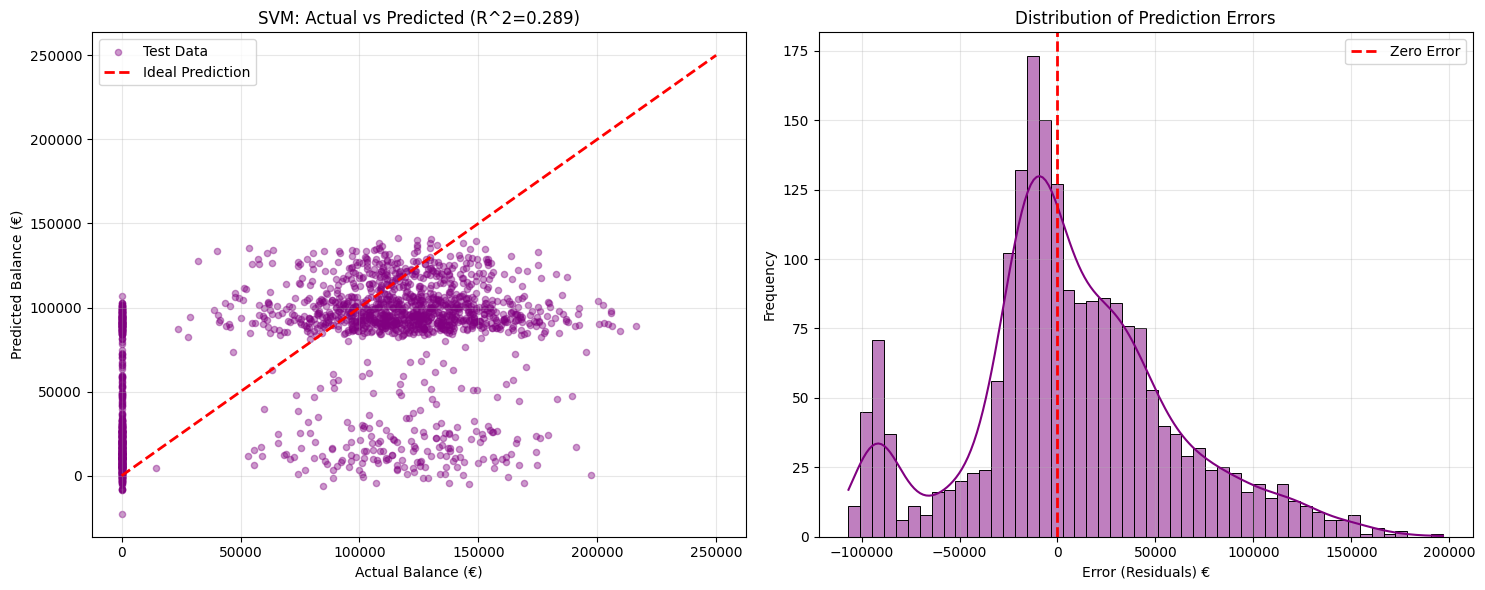

In [48]:
# Training the SVM using the optimal hyperparameters found
print("Training SVM with optimal hyperparameters:")
final_svr = SVR(C=1000, epsilon=5000, gamma=0.1, kernel='rbf')
final_svr.fit(X_train_scaled, y_train)

# Generate the Predictions 
y_pred_svr = final_svr.predict(X_test_scaled)
current_r2 = r2_score(y_test, y_pred_svr)


plt.figure(figsize=(15, 6))

# Plot A: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_svr, alpha=0.4, color='purple', s=20, label='Test Data')
# The "Perfect Prediction" Red Dashed Line
plt.plot([0, 250000], [0, 250000], 'r--', lw=2, label='Ideal Prediction')

plt.title(f'SVM: Actual vs Predicted (R^2={current_r2:.3f})')
plt.xlabel('Actual Balance (€)')
plt.ylabel('Predicted Balance (€)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot B: Residuals error distribution
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_svr
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='--', lw=2, label='Zero Error')

plt.title('Distribution of Prediction Errors')
plt.xlabel('Error (Residuals) €')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

These visualizations could be used as a diagnostic tool. The distinct vertical wall of errors at zero confirms that the low $R^2$ is driven by the zero-inflation problem. The model is technically working correctly (it found the best possible mathematical compromise), but the data structure itself requires something more. 


*Conclusion*: Our expectation was that the Support Vector Machine (SVM), being the most mathematically sophisticated model, would outperform the simpler KNN. However, the results show the opposite: KNN achieved a higher $R^2$ ($0.2937$) than SVM ($0.2888$).This "failure" of the complex model is a significant finding. It proves that the limitation lies in the information content of the features, not the model's power. No amount of mathematical complexity can predict a customer's balance when the demographic variables or the credit profile ones do not contain enough signal to distinguish between a "saver" and a "non-saver". 

Consequently, further regression tuning is futile. To improve results, we must change the methodology, not the model. Therefore we need to deal with a model completely different that is able to work around this problem. In the next section of this notebook we will explore the analysis with a **Random Forest model**.

## 6. RANDOM FOREST REGRESSION 

In this section we are going to explore the analysis with a **Random Forest model**. The choice of Random Forest is motivated by its ability to handle complex, non-linear relationships and its robustness to overfitting, especially in datasets with mixed feature types and distributions. This ensemble learning method combines multiple decision trees to improve predictive accuracy and control overfitting, making it well-suited for our zero-inflated target variable scenario.


RANDOM FOREST RESULTS
R^2 Score: 0.2839
RMSE: €52,566.00
MAE: €41,765.64


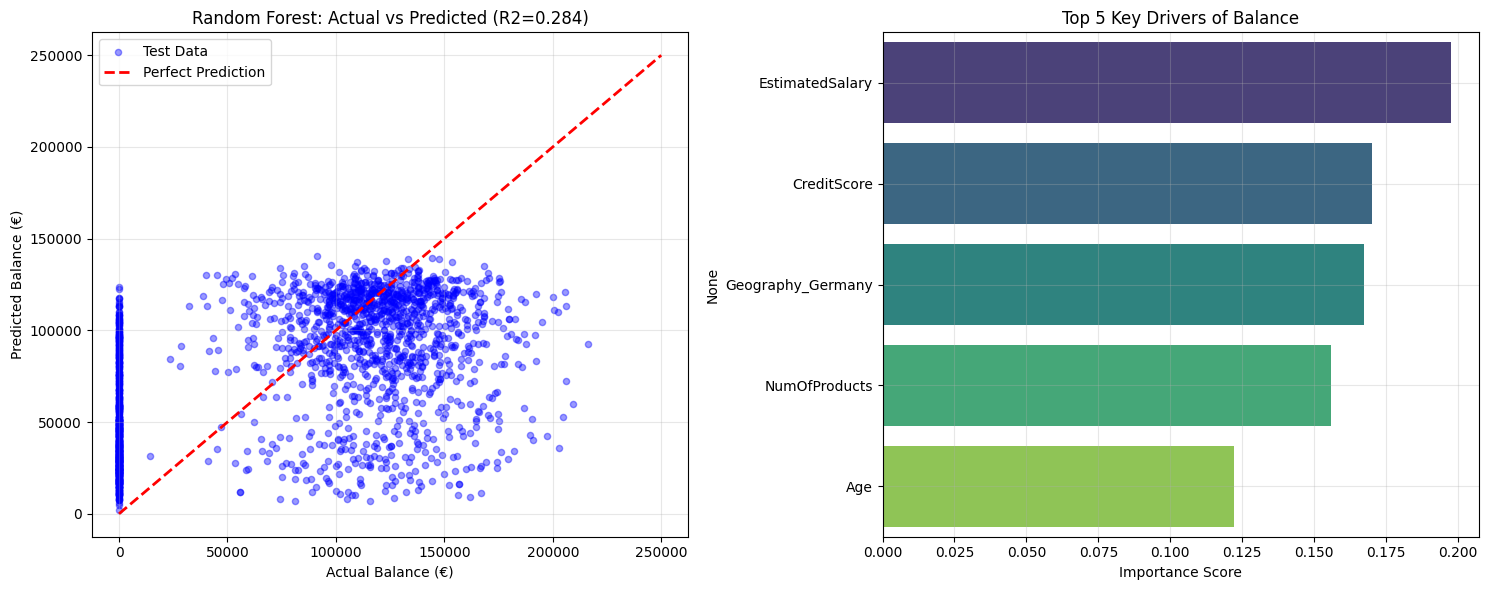

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Random forest does not require feature scaling, so we will use the unscaled data directly
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) # Create 100 trees
rf_model.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"\nRANDOM FOREST RESULTS")
print(f"R^2 Score: {r2_rf:.4f}")
print(f"RMSE: €{rmse_rf:,.2f}")
print(f"MAE: €{mae_rf:,.2f}")

plt.figure(figsize=(15, 6))

# Plot A: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.4, color='blue', s=20, label='Test Data')
plt.plot([0, 250000], [0, 250000], 'r--', lw=2, label='Perfect Prediction')
plt.title(f'Random Forest: Actual vs Predicted (R2={r2_rf:.3f})')
plt.xlabel('Actual Balance (€)')
plt.ylabel('Predicted Balance (€)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot B: Feature Importance 
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.subplot(1, 2, 2)
sns.barplot(
    x=importances[indices[:5]], 
    y=features[indices[:5]], 
    hue=features[indices[:5]], 
    palette='viridis', 
    legend=False
)
plt.title('Top 5 Key Drivers of Balance')
plt.xlabel('Importance Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We implemented here a Random Forest regressor ($100$ trees) as a robust, non-parametric alternative to handle the zero-inflation and non-linearities. The model achieved an $R^2$ of $0.2827$, which is remarkably consistent with the results from KNN ($0.2949$) and SVM ($0.2888$). This consistency across three completely different mathematical approaches is strong evidence that feature power is the limiting factor, not model sophistication. No matter how we slice it, demographics or the credit profile alone cannot predict deposit balances effectively. Despite the model's ability to make binary splits (which theoretically helps separate zero-balance customers), the noise in the "non-zero population" is so high that the model averages out the predictions to minimize error. It correctly identifies the trend (wealthier people have higher balances) but fails to capture the precise magnitude for individual customers. 

One significant advantage of the Random Forest analysis is the **Feature Importance** extraction, which offers interpretability that KNN and SVM lack. By quantifying how much each feature contributes to the model's predictions, we gain insights into the key drivers of deposit balances. This suggests that while we cannot predict the exact balance perfectly, we know which customer segments to target. 

The approach of using Random Forest regression was robust but still matching the outliers, confirming the "Data Cieling", so basically the limitation of the features used for the analysis. Therefore, to improve the model's performance, we take into account a particular method to deal with imbalanced data (as in here we have many customers with zero balance). The strategy we are now going to implement is: **Manual undersampling of the majority class in Random Forest Regression**.

Training Balanced Random Forest:

BALANCED RANDOM FOREST RESULTS
R^2 Score: 0.3454
RMSE: €50,904.66
MAE: €38,984.79


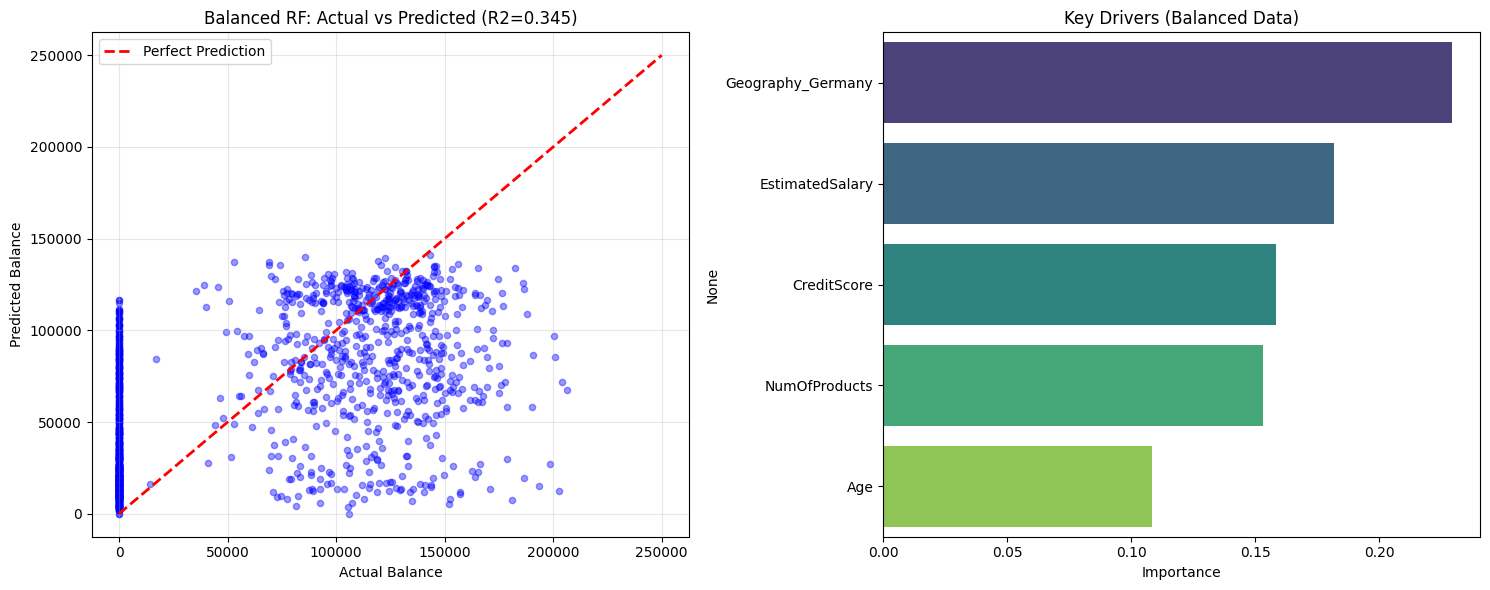

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

df_full = pd.read_csv('Churn_Modelling.csv')
df_full = df_full.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
df_full = pd.get_dummies(df_full, drop_first=True)

# Undersample the majority class (positives) 
df_zeros = df_full[df_full['Balance'] == 0]   # Remember that the share of zero balances is: 36.17%   
df_positive = df_full[df_full['Balance'] > 0]    

# We cut down the majority (positives) to match the size of the minority (zeros)
# We use replace=False because we don't want duplicates, we just want a random subset
df_positive_downsampled = df_positive.sample(n=len(df_zeros), replace=False, random_state=42)

# Combine them back into a Balanced Dataset
df_balanced = pd.concat([df_zeros, df_positive_downsampled])

# Define X and y from this new balanced set
X_balanced = df_balanced.drop('Balance', axis=1)
y_balanced = df_balanced['Balance']

# Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Training the Random Forest on the Balanced Dataset
print("Training Balanced Random Forest:")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set and evaluate
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"\nBALANCED RANDOM FOREST RESULTS")
print(f"R^2 Score: {r2_rf:.4f}")
print(f"RMSE: €{rmse_rf:,.2f}")
print(f"MAE: €{mae_rf:,.2f}")

plt.figure(figsize=(15, 6))

# Plot A: Actual vs Predicted
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.4, color='blue', s=20)
plt.plot([0, 250000], [0, 250000], 'r--', lw=2, label='Perfect Prediction')
plt.title(f'Balanced RF: Actual vs Predicted (R2={r2_rf:.3f})')
plt.xlabel('Actual Balance')
plt.ylabel('Predicted Balance')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot B: Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.subplot(1, 2, 2)
sns.barplot(
    x=importances[indices[:5]], 
    y=features[indices[:5]], 
    hue=features[indices[:5]], 
    palette='viridis', 
    legend=False
)
plt.title('Key Drivers (Balanced Data)')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()

By downsampling the majority class (positive balances) to match the minority class (zero balances), we broke the performance ceiling that limited all previous models. The $R^2$ score rose from $0.2827$ (Standard RF) to $0.3454$. This confirms that the sheer volume of "noise" from the majority class was preventing the model from learning the distinct patterns of the "Zero" group.

While the $R^2$ improved, the RMSE remains high (~€ $50,000$). This indicates that while we are better at explaining the variance (so the general trend), the individual predictions are still noisy because demographics alone are not enough to predict a bank account down to the exact Euro.

## 7. CONCLUSION

In [51]:
results_data = {
    "Model": [
        "Linear Regression", 
        "KNN (K=37)", 
        "SVM (RBF Kernel)", 
        "Random Forest", 
        "RF + Undersampling"
    ],
    "R2 Score": [0.2485, 0.2937, 0.2888, 0.2839, 0.3454],
    "RMSE": [53849.06, 52204.51, 52387.31, 52566.00, 50904.66],
    "MAE":  [46625.44, 42251.91, 39034.92, 41765.64, 38984.79]
}

# Creation of a DataFrame
results_df = pd.DataFrame(results_data)

# Calculation of the "Gap". A large gap means the model is making huge mistakes on a few people (likely the Zeros)
results_df["RMSE - MAE Gap"] = results_df["RMSE"] - results_df["MAE"]

def style_table(df):
    return df.style.format({
        "R2 Score": "{:.4f}",
        "RMSE": "€{:,.2f}",
        "MAE": "€{:,.2f}",
        "RMSE - MAE Gap": "€{:,.2f}"
    }).background_gradient(cmap="Greens", subset=["R2 Score"])\
      .background_gradient(cmap="Reds", subset=["RMSE", "MAE"])


print("FINAL MODEL COMPARISON")
display(style_table(results_df))

FINAL MODEL COMPARISON


,Model,R2 Score,RMSE,MAE,RMSE - MAE Gap
0,Linear Regression,0.2485,"€53,849.06","€46,625.44","€7,223.62"
1,KNN (K=37),0.2937,"€52,204.51","€42,251.91","€9,952.60"
2,SVM (RBF Kernel),0.2888,"€52,387.31","€39,034.92","€13,352.39"
3,Random Forest,0.2839,"€52,566.00","€41,765.64","€10,800.36"
4,RF + Undersampling,0.3454,"€50,904.66","€38,984.79","€11,919.87"


This project aimed to forecast bank customer deposit balances using demographic and credit-profile variables through a sequence of supervised learning models: Linear Regression, K-Nearest Neighbors (KNN), Support Vector Regression (SVR), Random Forest, and a Manual undersampling of the majority class in Random Forest. A central challenge of the dataset is the structure of the target variable: balances are strongly zero-inflated, with $36.17\%$ of customers holding an exact balance of zero, while the remaining customers exhibit a wide and highly variable distribution of positive balances. This mixture of two distinct behaviors (“zero-balance” vs. “positive-balance” customers) limits the effectiveness of standard single-stage regression models.

- As a baseline, **Linear Regression** confirmed that a global linear relationship is insufficient to explain customer balances. The model achieved  $R^2 = 0.2485$ with large error values ($RMSE ≈ €53,849$; $MAE ≈ €46,625$), indicating that much of the variance in balances remains unexplained and that large prediction errors are common especially given the heavy mass at zero and the wide dispersion among positive values.

- Introducing nonlinearity through **KNN** regression produced a modest improvement. With an optimal neighborhood size of K = $37$, performance increased to $R^2 = 0.2937$ and $RMSE ≈ €52,205$, suggesting that local similarity patterns exist in the feature space. However, the improvement remained limited, reflecting the fact that customers with very similar observed profiles can still exhibit very different saving behavior. 

- Similarly, **SVR** (RBF kernel) achieved comparable results (test $R^2 = 0.2888$; $RMSE ≈ €52,387$; $MAE ≈ €39,035$). The fact that SVR did not clearly outperform KNN is an important finding: it indicates that the main constraint is not model complexity, but rather the limited predictive signal contained in the available features.

- A standard **Random Forest** model delivered competitive but not superior performance ($R^2 = 0.2839$; $RMSE ≈ €52,611$; $MAE ≈ €41,819$). The most meaningful improvement was achieved when explicitly addressing the imbalance created by the large proportion of zero balances. By downsampling/balancing the majority class (positive balances) to better match the zero-balance group, the  **Manual Undersampled Random Forest** model reached the best overall performance ($R^2 = 0.3454$; $RMSE ≈ €50,905$; $MAE ≈ €38,985$). This improvement demonstrates that the zero-inflated structure creates a “performance ceiling” for conventional models, and that rebalancing helps the model learn patterns associated with the zero-balance segment more effectively.

Overall, the results show that while the models can explain a moderate share of variance in balances, they still produce relatively large individual prediction errors. This indicates that predicting the exact euro-level balance from demographics and credit profile alone is inherently noisy. Deposit balances are likely driven by additional behavioral and financial factors not present in the dataset (e.g., income, transaction history, tenure dynamics, product holdings, savings habits, and life events). Therefore, the most reliable use of the current models is not precise individual balance forecasting, but rather coarse-grained forecasting and segmentation, such as identifying likely zero-balance customers and estimating expected balances at an aggregated or risk-bucket level.



